# Contextual Bandits with Parametric Actions in Amazon SageMaker RL

We demonstrate how you can use varying number of actions with contextual bandits algorithms in SageMaker. This notebook builds on the [Contextual Bandits example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/reinforcement_learning/rl_hvac_coach_energyplus/rl_hvac_coach_energyplus.ipynb) which used fixed number of actions. Please refer to that notebook for basics on contextual bandits and the workflow used to train bandit policies in SageMaker. 

In the contextual bandit setting, an agent recommends an action given a state. This notebook introduces three features to bandit algorithms that makes them applicable to a broader set of real-world problems. We use the movie recommendation problem as an example.
1. The number of actions available to the agent can change over time. For example, the movies in the catalog changes over time. 
2. Each action may have features associated with it. For the movie recommendation problem, each movie can have features such as genre, cast, etc. 
3. The agent can pick multiple actions. When recommending movies, it is natural that multiple movies are recommended at a time.

The contextual bandit agent will trade-off between exploitation and exploration to quickly learn user preferences and minimize poor recommendations. The bandit algorithms are appropriate to use in recommendation problems when there are many cold items (items which have no or little interaction data) in the catalog or if user preferences change over time. 

<p align="center">
  <img src="workflow.png">
</p>

The contextual bandit training workflow is controlled by an experiment manager provided with this example. The client application (say a recommender system application) pings the SageMaker hosting endpoint that is serving the bandits model. The application sends the state (user features) as input and receives an action (recommendation) as a response. The client application sends the recommended action to the user and stores the received reward in S3. The SageMaker hosted endpoint also stores inference data (state and action) in S3. The experiment manager joins the inference data with rewards as they become available. The joined data is used to update the model with a SageMaker training job. The updated model is evaluated offline and deployed to SageMaker hosting endpoint if the model evaluation score improves upon prior models. 

Below is an overview of the subsequent cells in the notebook: 
* Configuration: this includes details related to SageMaker and other AWS resources needed for the bandits application. 
* IAM role setup: this creates appropriate execution role and shows how to add more permissions to the role, needed for specific AWS resources.
* Client application (Environment): this shows the simulated client application.
* Step-by-step bandits model development: 
 1. Model Initialization (random or warm-start) 
 2. Deploy the First Model 
 3. Initialize the Client Application 
 4. Reward Ingestion 
 5. Model Re-training and Re-deployment 
* Bandits model deployment with the end-to-end loop. 
* Visualization 
* Cleanup 

#### Local Mode

To facilitate experimentation, we provide a `local_mode` that runs the contextual bandit example using the SageMaker Notebook instance itself instead of SageMaker training and hosting instances. The workflow remains the same in `local_mode`, but runs much faster for small datasets. Hence, it is a useful tool for experimentation and debugging. However, it will not scale to production use cases with high throughput and large datasets. 

In `local_mode`, the training, evaluation and hosting is done with the SageMaker VW docker container. The join is not handled by SageMaker, and is done inside the client application. The rest of the textual explanation assumes that the notebook is run in SageMaker mode.

In [1]:
import yaml
import sys
import numpy as np
import time
import sagemaker
sys.path.append('common')
sys.path.append('common/sagemaker_rl')
from misc import get_execution_role
from markdown_helper import *
from IPython.display import Markdown

In [2]:
import os
import json

### Configuration

The configuration for the bandits application can be specified in a `config.yaml` file as can be seen below. It configures the AWS resources needed. The DynamoDB tables are used to store metadata related to experiments, models and data joins. The `private_resource` specifices the SageMaker instance types and counts used for training, evaluation and hosting. The SageMaker container image is used for the bandits application. This config file also contains algorithm and SageMaker-specific setups.  Note that all the data generated and used for the bandits application will be stored in `S3://SageMaker-{REGION}-{AWS_ACCOUNT_ID}/{experiment_id}/`.

In [3]:
# !pygmentize 'config.yaml'
config_file = 'config.yaml'
with open(config_file, 'r') as yaml_file:
    config = yaml.load(yaml_file)

> Please make sure that the `num_arms` parameter in the config is equal to the number of actions in the client application (which is defined in the cell below).

### IAM role setup
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use `utils` method `role = get_execution_role('role_name')` to create an execution role.

In [4]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Couldn't call 'get_role' to get Role ARN from role name gsaur to get Role path.


Using Sagemaker IAM role arn: 
arn:aws:iam::609956480270:role/sagemaker


#### Additional permissions for the IAM role
IAM role requires additional permissions for [AWS CloudFormation](https://aws.amazon.com/cloudformation/), [Amazon DynamoDB](https://aws.amazon.com/dynamodb/), [Amazon Kinesis Data Firehose](https://aws.amazon.com/kinesis/data-firehose/) and [Amazon Athena](https://aws.amazon.com/athena/). Make sure the SageMaker role you are using has the permissions.

In [5]:
display(Markdown(generate_help_for_experiment_manager_permissions(sagemaker_role)))

>It looks like your SageMaker role has insufficient premissions. Please do the following:
1. Go to IAM console to edit current SageMaker role: [sagemaker](https://console.aws.amazon.com/iam/home#/roles/sagemaker).
2. Click on policy starting with `AmazonSageMaker-ExecutionPolicy` and then edit policy.
3. Go to JSON tab, add the following JSON blob to the `Statement` list and save policy:
```json
        {
            "Effect": "Allow",
            "Action": [
                "firehose:*",
                "cloudformation:*",
                "dynamodb:*",
                "iam:*",
                "cloudwatch:*",
                "glue:*",
                "athena:*"
            ],
            "Resource": [
                "*"
            ]
        },```
4. Now wait for a few minutes before executing this cell again!

### Client application (MovieLens Environment)
The client application simulates a live environment that uses the SageMaker bandits model to serve recommendations to users. The logic of reward generation resides in the client application. We simulate the online learning loop with feedback using a recommendation simulator. The simulator uses MovieLens 100k dataset.

The workflow of the client application is as follows:
- **User sampling and candidate list generation**: The client application picks a user u and a list of 100 items (define by item_pool_size) at random, which is sent to the SageMaker endpoint for retrieving a recommendation. This list consists of the movies that the user u has rated in the past, as we know the true user preferences (ratings) for these movies.
- **Bandit Slate recommendation**: SageMaker endpoint returns a recommendation - a list of top-k items, associated probability and `event_id`.
- **Feedback generation by simulating user behaviour**: The reward is given to the agent based on user ratings in the dataset. We assume a Cascade Click model, where the user scans the list top-down, and clicks on the item that she likes. We give a reward of 0 to all the items above the clicked item and a reward to 1 to the item that was clicked.
- **Rewards logging**: The application reports the reward to the experiment manager using S3, along with the corresponding `event_id`.

`event_id` is a unique identifier for each interaction. It is used to join inference data `<shared_context, actions_context, action, action probability>` with the rewards. 

In a later cell of this notebook, where there exists a hosted endpoint, we illustrate how to interact with the endpoint and get the recommended actions.

#### MovieLens 100K usage license
Please be aware of the following requirements regarding acknowledgment, copyright and availability, cited from the [data set description page](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

The data set may be used for any research purposes under the following conditions:

 * The user may not state or imply any endorsement from the
   University of Minnesota or the GroupLens Research Group.
 * The user must acknowledge the use of the data set in
   publications resulting from the use of the data set
   (see below for citation information).
 * The user may not redistribute the data without separate
   permission.
 * The user may not use this information for any commercial or
   revenue-bearing purposes without first obtaining permission
   from a faculty member of the GroupLens Research Project at the
   University of Minnesota.
   
If you have any further questions or comments, please contact GroupLens (grouplens-info@cs.umn.edu).

##### Download the dataset

In [ ]:
%%bash

curl -o ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
unzip ml-100k.zip
rm ml-100k.zip

##### Initialize the environment

In [5]:
from src.env import MovieLens100KEnv

##### Environment Arguments  

- **top_k**: The size of the slate or the number of items that the agent will recommend. The environment
needs this to calculate the optimal expected reward.
- **item_pool_size**: The size of candidate list - environment will randomly select
these many items from the movies that the user has rated in the dataset. If None,
environment will use all the movies rated by the user.  
- **max_users**: The environment will sample from `max_users` only. If set to None,
all users i.e. 943 will be used for sampling. This parameter can be used to 
simplify the learning problem.


In [13]:
top_k = 5  # Bandit will recommend a list of 5 movies to every user
item_pool_size = 100

env = MovieLens100KEnv(data_dir="./ml-100k",
                       item_pool_size=item_pool_size,
                       top_k=top_k,
                       max_users=100)

### Step-by-step bandits model development

`ExperimentManager` is the top level class for all the Bandits/RL and continual learning workflows. Similar to the estimators in the [Sagemaker Python SDK](https://github.com/aws/sagemaker-python-sdk), `ExperimentManager` contains methods for training, deployment and evaluation. It keeps track of the job status and reflects current progress in the workflow.

Start the application using the `ExperimentManager` class 

In [14]:
from orchestrator.workflow.manager.experiment_manager import ExperimentManager

 The initialization below will set up an AWS CloudFormation stack of additional resources. 

In [15]:
# model_id length cannot exceed 63 characters under SM mode.
# evaluation job name will include timestamp in addition to train job name.
# So, make experimend_id as short as possible
experiment_name = "bandits-movielens-3"
bandits_experiment = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Using Resources in CloudFormation stack named: BanditsSharedResourceStackSG for Shared Resources.


#### 1. Model Initialization

To start a new experiment, we need to initialize the first model. In the case where historical data is available and is in the format of `<state, action, action probability, reward>`, we can warm start by learning the policy offline. Otherwise, we can initiate a random policy.

Here, let us start from scratch by initializing a random model.

In [16]:
bandits_experiment.initialize_first_model() 

INFO:orchestrator:Next Model name would be bandits-movielens-3-model-id-1574805631
INFO:orchestrator:Start training job for model 'bandits-movielens-3-model-id-1574805631''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpq54systp_algo-1-5ifjj_1_d4b5f4681d54 ... 
Attaching to tmpq54systp_algo-1-5ifjj_1_5626eae89128
algo-1-5ifjj_1_5626eae89128 | 2019-11-26 22:00:35,974 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-5ifjj_1_5626eae89128 | 2019-11-26 22:00:36,026 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-5ifjj_1_5626eae89128 | 2019-11-26 22:00:36,070 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-5ifjj_1_5626eae89128 | 2019-11-26 22:00:36,092 sagemaker-containers INFO     Invoking user script
algo-1-5ifjj_1_5626eae89128 | 
algo-1-5ifjj_1_5626eae89128 | Training Env:
algo-1-5ifjj_1_5626eae89128 | 
algo-1-5ifjj_1_5626eae89128 | {
algo-1-5ifjj_1_5626eae89128 |     "additional_framework_parameters": {
algo-1-5ifjj_1_5626eae89128 |         "sagemaker_estimator": "RLEstimator"
algo-1-5ifjj_1_5626eae89128 |     },
algo-1-5ifjj_1_5626eae89128 |     "channel_input_dirs": {},
algo-1-5ifjj_1

#### 2. Deploy the First Model

Once training and evaluation is done, we can deploy the model.

In [ ]:
bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id)

You can check the experiment state at any point by executing:

In [ ]:
bandits_experiment._jsonify()

The model just trained appears in both `last_trained_model_id` and `last_hosted_model_id`.

#### 3. Use the deployed model to generate recommendations

Now that the last trained model is hosted, we can send out the user and items embedding, and receive the recommended action.

In [19]:
predictor = bandits_experiment.predictor

In [15]:
obs = env.reset()
user_embedding = obs[0].tolist() if obs[0] else []
items_embedding = obs[1].tolist()
user_id = env.current_user_id

In [21]:
# Initialize a train buffer to store reward and the corresponding user and item embedding for training
train_buffer = []

# Initialize rewards and regret buffer to store all the rewards and regret for plotting the performance of bandit over time
all_regrets = []
all_regrets_random_actions = []

In [17]:
actions, event_id, model_id, action_probs, sample_prob = predictor.get_actions(shared_context=user_embedding,
                                                                               actions_context=items_embedding,
                                                                               top_k=top_k,
                                                                               user_id=user_id)
    
# Check prediction response by uncommenting the lines below
print('Selected actions: {}, event ID: {}, model ID: {}, probability: {}'.format(actions,
                                                                                event_id,
                                                                                model_id,
                                                                                action_probs))

Selected actions: [0, 1, 2, 3, 4], event ID: 229344638809753845684527396301617364994, model ID: bandits-movielens-2-model-id-1574804499, probability: [1.0, 1.0, 1.0, 1.0, 1.0]


#### 4. Reward Ingestion

Client application generates a reward after receiving the recommended action and stores the tuple `<eventID, reward>` in S3. In this case, reward is 1 if predicted action is the true class, and 0 otherwise. SageMaker hosting endpoint saves all the inferences `<eventID, shared_context, actions_context, action, action probability>` to S3 using [Kinesis Firehose](https://aws.amazon.com/kinesis/data-firehose/). The experiment manager joins the reward with state, action and action probability using [Amazon Athena](https://aws.amazon.com/athena/). 

In [18]:
local_mode = bandits_experiment.local_mode
batch_size = 400 # collect 100 data instances
print("Collecting batch of experience data...")

obs = env.reset()

# Generate experiences and log them
for i in range(batch_size):
    user_embedding = obs[0].tolist() if obs[0] else []
    items_embedding = obs[1].tolist()
    user_id = env.current_user_id
    actions, event_id, model_id, action_probs, sample_prob = predictor.get_actions(shared_context=user_embedding,
                                                                                   actions_context=items_embedding,
                                                                                   top_k=top_k,
                                                                                   user_id=user_id)
    obs, rewards, done, info = env.step(actions)
    
    for index, reward in enumerate(rewards):
        # Store feedback in train_buffer
        blob = {"reward": reward,
                 "event_id": event_id,
                 "action": actions[index],
                 "action_prob": action_probs[index],
                 "model_id": model_id,
                 "shared_context": user_embedding,
                 "actions_context": items_embedding,
                 "user_id": user_id,
                 "sample_prob": sample_prob}
        train_buffer.append(blob)
    all_regrets.append(info["total_regret"])
    all_regrets_random_actions.append(info["total_random_regret"])
    
# Join (observation, action) with rewards (can be delayed) and upload the data to S3
if local_mode:
    bandits_experiment.ingest_joined_data(train_buffer, ratio=1)
else:
    print("Waiting for firehose to flush data to s3...")
    time.sleep(60) # Wait for firehose to flush data to S3
    rewards_s3_prefix = bandits_experiment.ingest_rewards(train_buffer)
    bandits_experiment.join(rewards_s3_prefix)
    
train_buffer[:] = []

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 1
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-609956480270/bandits-movielens-2/joined_data/bandits-movielens-2-join-job-id-1574804576


In [19]:
bandits_experiment.last_joined_job_train_data

's3://sagemaker-us-west-2-609956480270/bandits-movielens-2/joined_data/bandits-movielens-2-join-job-id-1574804576/train'

In [20]:
# Check the workflow to see if join job has completed successfully
bandits_experiment._jsonify()

{'experiment_id': 'bandits-movielens-2',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-movielens-2-model-id-1574804499',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': 'DEPLOYED',
  'last_hosted_model_id': 'bandits-movielens-2-model-id-1574804499',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-movielens-2-join-job-id-1574804576',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

#### 5. Model Re-training and Re-deployment

Now we can train a new model with newly collected experiences, and host the resulting model.

In [ ]:
bandits_experiment.train_next_model(input_data_s3_prefix=bandits_experiment.last_joined_job_train_data)

In [22]:
bandits_experiment.last_trained_model_id

'bandits-movielens-2-model-id-1574804594'

In [ ]:
# deployment takes ~10 min if `local_mode` is False
bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id)

In [24]:
bandits_experiment.last_hosted_model_id

'bandits-movielens-2-model-id-1574804594'

### Bandits model deployment with the end-to-end loop

The above cells explained the individual steps in the training workflow. To train a model to convergence, we will continually train the model based on data collected with client application interactions. We demonstrate the continual training loop in a single cell below.

Details of each joining and training job can be tracked in `join_db` and `model_db` respectively. `model_db` also stores the evaluation scores. When you have multiple experiments, you can check their status in `experiment_db`.

In [ ]:
start_time = time.time()
total_loops = 10 # Increase for higher accuracy
batch_size = 150 # Model will be trained after every 150 data instances

obs = env.reset()

local_mode = bandits_experiment.local_mode
for loop_no in range(total_loops):
    print(f"""
    #################
    #################
         Loop {loop_no+1}
    #################
    #################
    """)

    
    for i in range(batch_size):
        user_embedding = obs[0].tolist() if obs[0] else []
        items_embedding = obs[1].tolist()
        user_id = env.current_user_id
        actions, event_id, model_id, action_probs, sample_prob = predictor.get_actions(shared_context=user_embedding,
                                                                                       actions_context=items_embedding,
                                                                                       top_k=top_k,
                                                                                       user_id=user_id)
        obs, rewards, _, info = env.step(actions)

        for index, reward in enumerate(rewards):
            # Store feedback in train_buffer
            blob = {"reward": reward,
                     "event_id": event_id,
                     "action": actions[index],
                     "action_prob": action_probs[index],
                     "model_id": model_id,
                     "shared_context": user_embedding,
                     "actions_context": items_embedding,
                     "user_id": user_id,
                     "sample_prob": sample_prob}
            train_buffer.append(blob)
            
        all_regrets.append(info["total_regret"])
        all_regrets_random_actions.append(info["total_random_regret"])
    
    # Local/Athena join
    if local_mode:
        bandits_experiment.ingest_joined_data(train_buffer,ratio=1)
    else:
        print("Waiting for firehose to flush data to s3...")
        time.sleep(60) 
        rewards_s3_prefix = bandits_experiment.ingest_rewards(train_buffer)
        bandits_experiment.join(rewards_s3_prefix, ratio=1)
    
    # Train 
    bandits_experiment.train_next_model(input_data_s3_prefix=bandits_experiment.last_joined_job_train_data)

    bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id)
    
    train_buffer[:] = []

print(f"Total time taken to complete {total_loops} loops: {time.time() - start_time}")

### Visualization

You can visualize the model performance along the training loop by plotting the cumulative regret across client interactions. Regret is defined as the difference between the optimal reward and the actual reward obtained by the agent at each time step.

> Note: The plot below cannot be generated if the notebook has been restarted after the execution of the cell above. 



In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

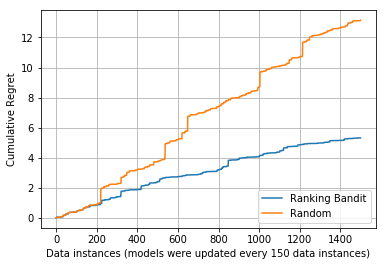

In [24]:
plt.plot(all_regrets, label="Ranking Bandit")
plt.plot(all_regrets_random_actions, label="Random")

plt.legend(loc=4, prop={'size': 10},)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Data instances (models were updated every %s data instances)' % batch_size, size=10)
plt.ylabel('Cumulative Regret', size=10)
plt.grid()
plt.show()

As we can see from the graph, the bandit agent learns the user preferences over time and performs much better than picking movies randomly from the candidate list.

### Clean up

We have three DynamoDB tables (experiment, join, model) from the bandits application above (e.g. `experiment_id='bandits-exp-1'`). To better maintain them, we should remove the related records if the experiment has finished. Besides, having an endpoint running will incur costs. Therefore, we delete these components as part of the clean up process.

> Only execute the clean up cells below when you've finished the current experiment and want to deprecate everything associated with it. After the cleanup, the Cloudwatch metrics will not be populated anymore.

In [ ]:
bandits_experiment.clean_resource(experiment_id=bandits_experiment.experiment_id)

In [ ]:
bandits_experiment.clean_table_records(experiment_id=bandits_experiment.experiment_id)

## Local testing

Use the cell below for fast testing. VW C++ CLI should be installed on your machine for this to work.

In [10]:
env = MovieLens100KEnv(data_dir="./ml-100k", item_pool_size=item_pool_size, top_k=top_k, max_users=100)

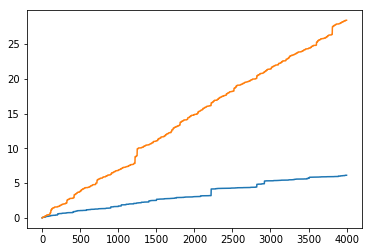

In [25]:
from src.vw_agent import VWAgent

agent = VWAgent(cli_args="--cb_explore_adf --cb_type mtr --regcbopt --mellowness 0.01")

# Start the VW C++ process
agent.start()


all_regrets = []
all_regrets_random = []

done = False
num_iterations = 4000
all_scores_str = []

obs = env.reset()

for i in range(num_iterations):
    done = False

    user, items = obs
    current_user_id = env.current_user_id


    actions, probs = agent.choose_actions(user, items, top_k=5, user_id=current_user_id)

    # Execute the action to step the environment
    obs, rewards, done, info = env.step(actions)
    all_regrets.append(info["total_regret"])
    all_regrets_random.append(info["total_random_regret"])

    for index, reward in enumerate(rewards):
        agent.learn(user, items, action_index=actions[index], reward=reward,
                        action_prob=probs[index], cost_fn= lambda reward: -reward, user_id=current_user_id)


plt.plot(all_regrets)
plt.plot(all_regrets_random)

In [ ]:
agent.close()